# Data Prep

In this notebook I will import and inspect the image and telemetry data taken from Donkey Sim, and organize it for modeling steps.

* Import telemetry .csv
* Import image data
* Convert image data
* Create dataframe with: 
  * steering inputs, 
  * throttle inputs
  * converted imageds
* Save as a pickle format file for modeling

In [1]:
## Imports
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2021-11-15 17:22:31.241405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Telemetry Data

Steps:
* load simulation telemetry data csv
* cut unneeded columns
* cut incomplete last lap
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


In [2]:
## Constants
working_date = '11_15_2021'
working_time = '16_45_55'
local_project_path = '/home/grant/projects/donkeysim-client/data'


# telemetry_columns = ['speed','pitch', 'yaw', 'roll', 'activeNode'] 
telemetry_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 
               'gyro_z', 'vel_x', 'vel_y', 'vel_z',]

In [3]:
## Directories
local_data_directory = f'{local_project_path}/{working_date}/{working_time}'
local_image_directory = f'{local_data_directory}/images'
working_data_directory = f'../data/{working_date}/{working_time}'

## File paths
telemetry_csv = f'{local_data_directory}/data.csv'
input_image_dataset_file = f'{working_data_directory}/X_img.npy'
input_telem_dataset_file = f'{working_data_directory}/X_telem.pkl'
target_dataset_file = f'{working_data_directory}/y.npy'

In [4]:
## Make sure directoires exist
os.makedirs(working_data_directory, exist_ok=True)

### Load CSV file as DataFrame

In [5]:
df = pd.read_csv(telemetry_csv)
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,on_road,progress_on_shortest_path,lap
0,0.0,0.288367,0.002421,119.3352.PNG,none,119.3352,0.002088,-0.009022,0.016053,-0.000026,...,307,14.04008,0.565460,-68.18536,0.000146,-0.001962,0.001410,0,0,0
1,0.0,0.321603,0.046481,119.3851.PNG,none,119.3851,-0.006086,0.002063,1.279279,0.000396,...,307,14.03885,0.565202,-68.18661,0.000089,-0.002076,0.046434,0,0,0
2,0.0,0.351906,0.107482,119.4351.PNG,none,119.4351,-0.003280,0.017245,1.729377,0.000724,...,307,14.03514,0.564731,-68.19048,0.000083,-0.001152,0.107476,0,0,0
3,0.0,0.353861,0.135307,119.4847.PNG,none,119.4847,-0.016222,0.033200,0.805473,0.000624,...,307,14.03131,0.564488,-68.19459,-0.000178,0.000132,0.135306,0,0,0
4,0.0,0.376344,0.185702,119.5351.PNG,none,119.5351,0.028342,0.048648,-0.053816,0.000329,...,307,14.02357,0.564441,-68.20283,0.000049,0.002027,0.185691,0,0,0


### Rename Steering Column to Match Throttle

In [6]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

In [7]:
## drop message label column
# df.reset_index(drop=True, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41883 entries, 0 to 41882
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   steering                   41883 non-null  float64
 1   throttle                   41883 non-null  float64
 2   speed                      41883 non-null  float64
 3   image                      41883 non-null  object 
 4   hit                        41883 non-null  object 
 5   time                       41883 non-null  float64
 6   accel_x                    41883 non-null  float64
 7   accel_y                    41883 non-null  float64
 8   accel_z                    41883 non-null  float64
 9   gyro_x                     41883 non-null  float64
 10  gyro_y                     41883 non-null  float64
 11  gyro_z                     41883 non-null  float64
 12  gyro_w                     41883 non-null  float64
 13  pitch                      41883 non-null  flo

In [9]:
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

### Pare Useless Columns

In [10]:
drop_columns = ['hit', 'time', 'gyro_w', 'pitch', 'yaw', 'roll', 
                'totalNodes', 'pos_x', 'pos_y', 'pos_z', 'on_road',
                'progress_on_shortest_path']

In [11]:
df['lap'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [12]:
sys.getsizeof(df)

14149637

In [13]:
df.dtypes

steering                     float64
throttle                     float64
speed                        float64
image                         object
hit                           object
time                         float64
accel_x                      float64
accel_y                      float64
accel_z                      float64
gyro_x                       float64
gyro_y                       float64
gyro_z                       float64
gyro_w                       float64
pitch                        float64
yaw                          float64
roll                         float64
cte                          float64
activeNode                     int64
totalNodes                     int64
pos_x                        float64
pos_y                        float64
pos_z                        float64
vel_x                        float64
vel_y                        float64
vel_z                        float64
on_road                        int64
progress_on_shortest_path      int64
l

### Convert datatypes (?)

In [14]:
for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = pd.to_numeric(df[col], downcast='float')

In [15]:
sys.getsizeof(df)

10631465

### Remove "Extra" Laps

In [16]:
## Cut off the little bit after the end of the training session
df = df.loc[(df['lap'] > 0) & (df['lap'] < df['lap'].max()), :] #.drop(columns='lap')
df['lap'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

### Convert lap to category

In [17]:
df.loc[:, 'lap'] = df.loc[:, 'lap'].astype('category')

In [18]:
sys.getsizeof(df)

10632889

### Create lap time df

In [19]:
laps = pd.DataFrame(df.groupby(by='lap')['time'].describe()[['max', 'min']])
laps.head()

,max,min
lap,,
1,167.090805,121.135399
2,208.794800,167.140594
3,250.900101,208.844696
4,293.141602,250.950897
5,335.045807,293.192108


In [20]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    50.000000
mean     41.664898
std       0.985650
min      40.453003
25%      41.162933
50%      41.580505
75%      41.906487
max      45.955406
Name: lap_time, dtype: float64

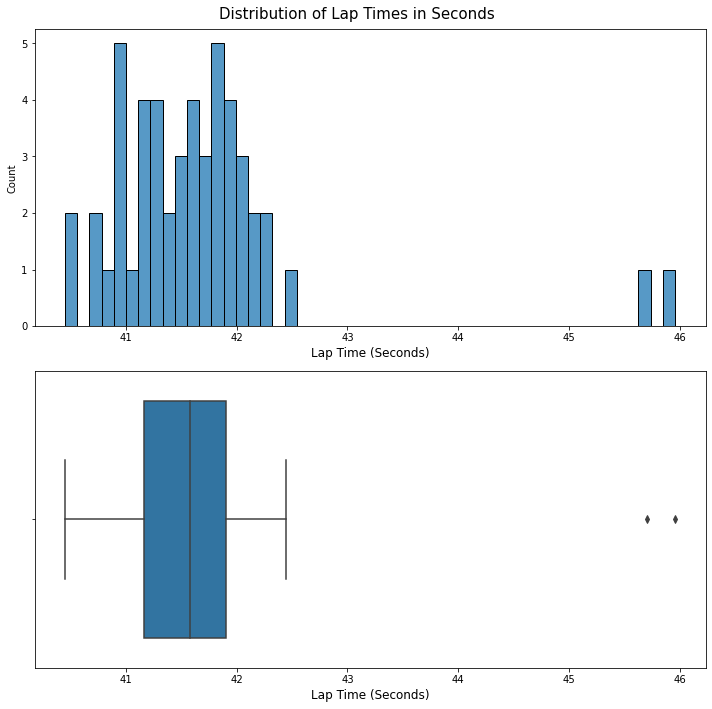

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [22]:
len(laps[laps['lap_time']>43])

2

### Add lap times to df to make sorting easier

In [23]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='lap', right_index=True).copy()

### Cut laps longer than 43 seconds

In [24]:
df = df.loc[df['lap_time'] < 43, :].copy()
df.drop(columns=['lap', 'time'], inplace=True)
df.shape

(39880, 27)

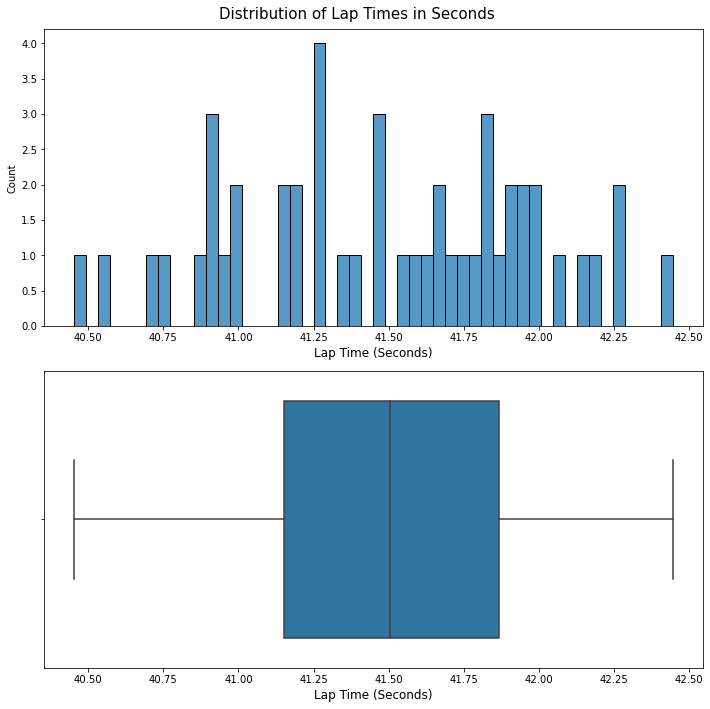

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [26]:
laps = laps.loc[laps['lap_time'] < 43]

In [27]:
laps['lap_time'].describe()

count    48.000000
mean     41.491364
std       0.493268
min      40.453003
25%      41.150848
50%      41.504456
75%      41.866501
max      42.444885
Name: lap_time, dtype: float64

### Save Telemetry Data

Doing so after cutting laps.

In [28]:
X_telem = df[telemetry_columns]
X_telem.describe()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,vel_x,vel_y,vel_z
count,39880.000000,39880.000000,39880.000000,39880.000000,39880.000000,39880.000000,39880.000000,39880.000000,39880.000000
mean,-0.000634,-0.001540,-0.002991,0.000011,0.001513,-0.000020,-0.320478,-0.122737,12.591679
std,1.978954,1.383843,4.338062,0.001205,0.005157,0.001305,0.693201,0.233046,2.431565
min,-26.138760,-6.612081,-12.642620,-0.012155,-0.021971,-0.010486,-2.875154,-0.731579,6.597733
25%,-1.111047,-0.952832,-2.693641,-0.000644,-0.000689,-0.000739,-0.863517,-0.346454,10.783140
50%,0.018060,-0.048896,0.418270,0.000011,0.001672,-0.000001,-0.249171,-0.025066,12.839550
75%,1.118016,0.913248,3.320777,0.000671,0.005569,0.000699,0.023851,0.060093,14.237900
max,12.198070,9.264986,10.112000,0.011035,0.014801,0.008177,3.895848,0.737818,18.286360


In [29]:
## Save as pickle
X_telem.to_pickle(input_telem_dataset_file)

## Image Data

In [30]:
df = df[['steering', 'throttle', 'image', ]]

### Verify Files

In [31]:
## Verify Files
os.listdir(local_image_directory)[:5]

['728.8884.PNG',
 '707.2343.PNG',
 '2182.287.PNG',
 '1997.448.PNG',
 '687.8996.PNG']

## Create Image Array

In [32]:
## Using keras, load images as list, adding to a list
img_array_list = []
for img in df['image']:
    img_array_list.append(img_to_array(load_img(f"{local_image_directory}/{img}", 
                                                color_mode='grayscale',))) 
                                                # target_size=(60, 80))))

In [33]:
## convert list of arrays into a numpy array (of arrays())
X_img = np.array(img_array_list)

### Scale Image Data

In [34]:
X_img /= 255

## Create Datasets

### Create Targets

In [35]:
## Target: throttle and steering data
# y = df.drop(columns=['image']).to_numpy().copy()
y = df.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (39880, 64, 64, 1)
y.shape: (39880, 2)


### Save Datasets

In [36]:
## Save as binary NumPy .npy format
with open(input_image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)